In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from bisect import bisect_right
from copy import deepcopy
import seaborn as sns
import os
from zipfile import ZipFile
from scipy import stats
import random
import cv2

In [2]:
random.seed(42)
sns.set()

In [3]:
def load_pkl(fp):
    with open(fp, 'rb') as file:
        result = pickle.load(file)
    return result

Read pickle file from analized outcome by the Nesnet model

In [20]:
def weird_load(fp, sys='win_H'):
    if sys == 'win_H': 
        length = 2064
    elif sys == 'win':
        length = 3624
    elif sys == 'linux':
        length = 3408
        
    container = {}
    n = 0
    with open(fp, 'rb') as file:
        while True:
            chunk = file.read(length) #in windows system the length is 2064; in Linux it's 3408
            if not chunk:
                break
            try:
                data = pickle.loads(chunk)
                container.update(data)
            except:
                file.seek(length, 1)
                probe = file.read(10)
                while probe != b'\x80\x04\x95\x05\x08\x00\x00\x00\x00\x00':
                    file.seek(-9, 1)
                    probe = file.read(10)
                file.seek(-10, 1)
    return container

In [63]:
def to_case(result):
    outcome = defaultdict(list)
    for area in result.keys():
        if '.zip' in area:
            case_n = area.split('.zip', 1)[0]
        else:
            case_n = os.path.basename(os.path.dirname(area))
        outcome[case_n].append(area)
    return outcome

In [6]:
def profile_count(case_dict):
    outcome = {}
    for case_n, areas in case_dict.items():
        count = len(areas)
        outcome[case_n] = count
    return outcome

In [7]:
def profile_threshold(case_dict, result, threshold=0.99, threshes=np.arange(0.96, 1.00, 0.01)):
    outcome = defaultdict(list)
    compare = defaultdict(list)
    thresh_num_temp = {thresh:defaultdict(int) for thresh in threshes}
    for case_n, areas in case_dict.items():
        for area in areas:
            p = result[area]
            idx = bisect_right(threshes, p)-1
            if idx >= 0:
                loc = threshes[idx]
                thresh_num_temp[loc][case_n] += 1
            if p >= threshold:
                outcome[case_n].append(area)
            elif p < 0.5:
                compare[case_n].append(area)
    return outcome, thresh_num_temp, compare

In [8]:
def refine_thresh_num_temp(thresh_num_temp, threshes, case_dict):
    thresh_num = deepcopy(thresh_num_temp)
    cases = case_dict.keys()
    threshes = threshes[::-1]
    for idx, thresh in enumerate(threshes[1:], 1):
        pre_thresh = threshes[idx-1]
        for case_n in cases:
            thresh_num[thresh][case_n] += thresh_num[pre_thresh][case_n]
    return thresh_num

In [9]:
def population_plot(thresh_num):
    x, y_min, y_max, y_all = [], [], [], []
    for thresh, counts in thresh_num.items():
        vals = counts.values()
        x.append(thresh)
        y_min.append(min(vals))
        y_max.append(max(vals))
    plt.figure()
    sns.lineplot(x=x, y=y_min, label='min count')
    sns.lineplot(x=x, y=y_max, label='max count')
    plt.xlim(right=1.005)
    plt.ylabel('number')
    plt.xlabel('threshold')

In [10]:
def bar_plot(thresh_num):
    x, y = [], []
    for thresh, counts in thresh_num.items():
        x.append(round(thresh, 2))
        y.append(sum(counts.values()))
    fig, ax = plt.subplots()
    ax.set_ylabel('number')
    ax.set_xlabel('threshold')
    ax = sns.barplot(x=x, y=y)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    fig.tight_layout()

In [11]:
def dis_plot(selected_area):
    num = [len(areas) for areas in selected_area.values()]
    print(stats.describe(num))
    plt.figure()
    sns.distplot(num)
    plt.ylabel('density')
    plt.xlabel('number')

In [12]:
def showcase(dir_p, selected_area, compare):
    cases = list(selected_area.keys())
    show_cases = random.choices(cases, k=10)
    fig, axes = plt.subplots(ncols=10, nrows=2, figsize=(50,10))
    for idx, case in enumerate(show_cases):
        positive = random.choice(selected_area[case])
        negetive = random.choice(compare[case])
        with ZipFile(os.path.join(dir_p, f'{case}.zip'), 'r') as temp_zip:
            pos_data = temp_zip.read(positive[-25:])
            neg_data = temp_zip.read(negetive[-25:])
        pos_img = cv2.imdecode(np.frombuffer(pos_data, np.uint8), 3)
        neg_img = cv2.imdecode(np.frombuffer(neg_data, np.uint8), 3)
        axes[0, idx].set_title(case)
        axes[0, idx].imshow(cv2.cvtColor(pos_img, cv2.COLOR_BGR2RGB))
        axes[1, idx].imshow(cv2.cvtColor(neg_img, cv2.COLOR_BGR2RGB))
        axes[0, idx].axis('off')
        axes[1, idx].axis('off')

In [64]:
a = weird_load('../../archive/outcome1.pkl')
b = weird_load('../../archive/outcome2.pkl')
c = weird_load('../../archive/outcome3.pkl')
d = weird_load('../../archive/outcome4.pkl', sys='win')
e = weird_load('../../archive/outcome5.pkl', sys='win')

a.update(b)
a.update(c)
a.update(d)
a.update(e)
result = a

KeyboardInterrupt: 

In [51]:
a_file = '../../archive/outcome5.pkl'
result = weird_load(a_file, sys='win')
case_dict = to_case(result, mode=2)

In [46]:
case_dict = to_case(result)

In [18]:
"""the following marked codes are used to handel the work completed by a Linux server"""
# result = weird_load('../../archive/outcome0.pkl', sys='linux')
# case_dict = to_case(result, mode=2)

In [53]:
case_count = profile_count(case_dict)

In [54]:
threshes = np.arange(0.90, 1.01, 0.01)
selected_area, thresh_num_temp, compare = profile_threshold(case_dict, result, threshes=threshes)

In [56]:
# import shutil

# def aux_move(selected_area):
#     """use for the areas selected by local PC or Linux server"""
#     for case, f_ps in selected_area.items():
# #         scr_dir_p = f'../../selected/{case}'
#         scr_dir_p = f'e:/special/{case}'
#         dst_dir_p = f'../../selected/{case.split(".")[0]}'
#         os.makedirs(dst_dir_p, exist_ok=True)
#         for f_p in f_ps:
#             file = os.path.basename(f_p)
#             scr = os.path.join(scr_dir_p, file)
#             shutil.copy(scr, dst_dir_p)

# aux_move(selected_area)

In [61]:
# def long_name(path):
#     for dir_n in os.listdir(path):
#         if len(dir_n) > 23:
#             scr_dir_p = os.path.join(path, dir_n)
#             dst_dir_p = 'e:/archive'
#             shutil.move(scr_dir_p, dst_dir_p)

In [62]:
# long_name('../../selected/')

In [18]:
thresh_num = refine_thresh_num_temp(thresh_num_temp, threshes, case_dict)

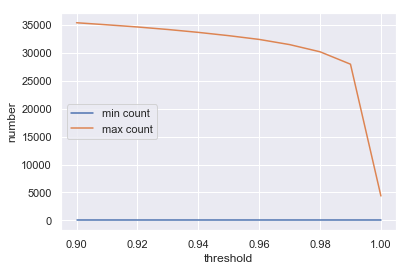

In [19]:
population_plot(thresh_num)

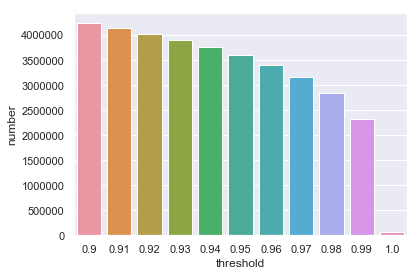

In [20]:
bar_plot(thresh_num)

As you see form the figure above, the 0.99 is a turning point. 1.00 is more restrict. Only few positive images, i.e. which will be used to train SCNN, is there, though. Thus, I used 0.99 as the threshold to filter areas.

DescribeResult(nobs=698, minmax=(1, 27971), mean=3336.8868194842407, variance=12700960.057473086, skewness=2.373934663233584, kurtosis=9.090577198529585)


C:\Anaconda3\envs\eos\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


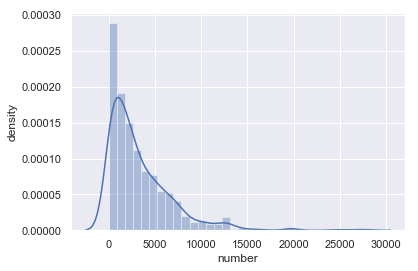

In [21]:
dis_plot(selected_area)

0.99 is a nice threshold. From the figure above, it's obvious the numbers of useful areas for most cases are under 3K. Compared to about 30K pre-selected areas. It seems the method that replace mannual select cancer areas worked.

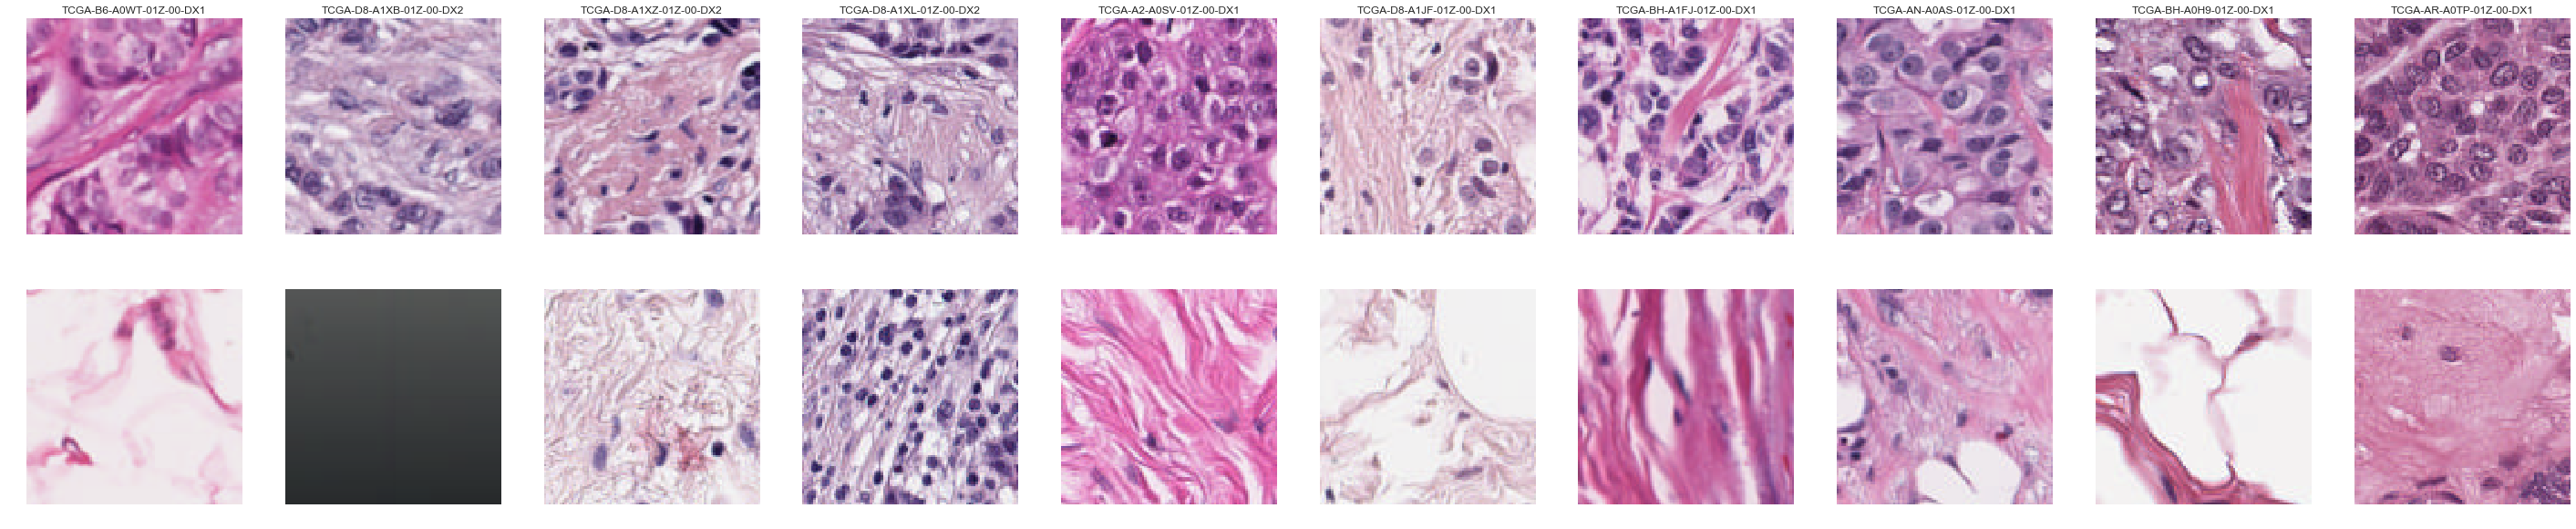

In [29]:
showcase('j:/archive/', selected_area, compare)

I randomly selected 10 cases and randomly choiced a cancer area and non-cancer area from each case to show the result of cancer area detection. As the figure above shows, the possible cancer areas are in first row; the non-cancer areas are in the second row.

In [23]:
cur_dst = '../../selected'
def done(dst=cur_dst):
    return set(os.listdir(cur_dst))

In [24]:
def extract(dir_p, selected_area):
    cur_done = done(cur_dst)
    n = 0
    for case, areas in selected_area.items():
        if case in cur_done:
            continue
        dst = f'{cur_dst}/{case}'
        os.makedirs(dst)
        with ZipFile(os.path.join(dir_p, f'{case}.zip'), 'r') as temp_zip:
            for area in areas:
                file = area[-25:]
                temp_zip.extract(file, path=dst)
        n += 1
        print(f'{n:03}{case} is done')

In [25]:
# extract('j:/archive/', selected_area)

In [26]:
def download_fps(selected_area):
    with open('selected_area.txt', 'w+') as command:
        suffix = ';'
        line = f'mkdir ../download{suffix}'
        command.write(line)
        for case_n, areas in selected_area.items():
            case_p = f'../download/{case_n}'
            line = f'mkdir {case_p}{suffix}'
            command.write(line)
            for area in areas:
                line = f'mv {area} {case_p}/{suffix}'
                command.write(line)

In [27]:
# download_fps(selected_area)